In [1]:
pip install einops

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

import my_utils as mu

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import  SubsetRandomSampler  #for validation test
from torch.optim import Adam
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, TensorDataset

import warnings
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
warnings.filterwarnings('ignore')

from einops import rearrange

Mounted at /content/gdrive




---



---



# **Section 1: Stem**

# Load and Iterate through Data

In [3]:
# NNDL
# Read training and test data
batch_size = 60000

train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
type(train_iter)

torch.utils.data.dataloader.DataLoader

In [4]:
# Printing the original data

for i, (images, labels) in enumerate(train_iter):

  with torch.no_grad():
    images = (images)
    labels = (labels)
    print(images, labels)

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..

In [5]:
# Iterate through loaded data
trainiter = iter(train_iter)
testiter = iter(test_iter)

images, labels = trainiter.next()

print(images.size())
print(labels.size())

torch.Size([60000, 1, 28, 28])
torch.Size([60000])


## Split Image Into Patches

In [6]:
# Form patches
patch = rearrange(images, 'b c (h1 h) (w1 w) -> (b h1 w1) c h w', h1=1, w1=2)
patch.shape

torch.Size([120000, 1, 28, 14])

In [7]:
# Data augmentation (flip images)
aug = TF.rotate(patch, 180)
df = pd.DataFrame(labels)

In [8]:
# Create labels for new dataset
new_labels = pd.DataFrame(np.repeat(df.values, 2, axis=0))

new_labels.columns = df.columns
new_labels = new_labels.to_numpy()
new_labels = torch.tensor(new_labels)
new_labels = torch.flatten(new_labels)
print(new_labels.size())

torch.Size([120000])




---



# Visualising Data

Figure 1 shows a sample of the dataset. That is, a number of fashion item images.

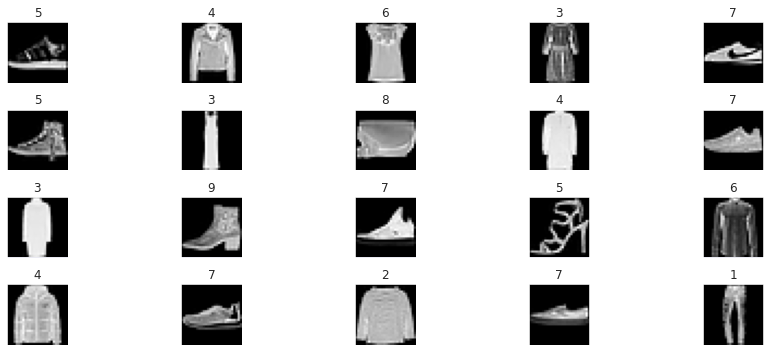

In [9]:
# Link 1
# Figure 1

fig = plt.figure(figsize=(15,5))  
for idx in np.arange(20):

  ax = fig.add_subplot(4, 10/2, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  ax.set_title(labels[idx].item())

  fig.tight_layout()

Figure 2 shows the original dataset split into patches as required. Initially, the images were split into 4 patches. This reduced model accuracy. Therefore the images were split into 2 patches as shown.

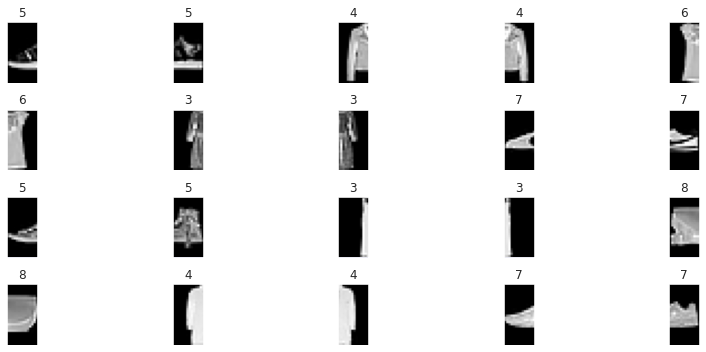

In [10]:
# Link 1
# Figure 2

fig = plt.figure(figsize=(15,5))  
for idx in np.arange(20):

  ax = fig.add_subplot(4, 10/2, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(patch[idx]), cmap='gray')
  ax.set_title(new_labels[idx].item())

  fig.tight_layout()

Figure 3 shows a smaple of the augmented dataset. It is the same as the data shown in figure 2 but rotated 180 degrees. This increases the training data available for the model.

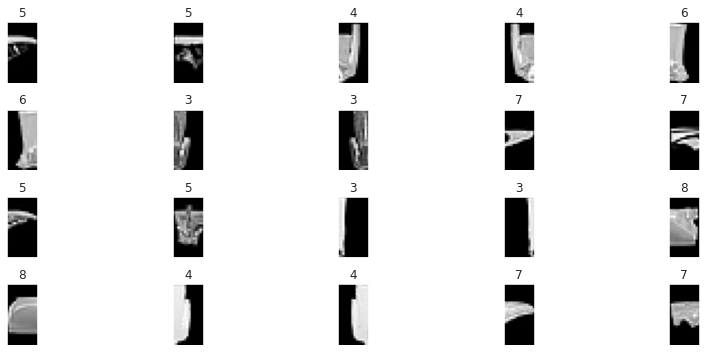

In [11]:
# Link 1
# Figure 3

fig = plt.figure(figsize=(15,5))  
for idx in np.arange(20):

  ax = fig.add_subplot(4, 10/2, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(aug[idx]), cmap='gray')
  ax.set_title(new_labels[idx].item())

  fig.tight_layout()

The data is arranged in a way that allows for simple concatanation. The normal patches shown in figure 2 form the first 120,000 sampels. Those samples are then augmented and concatonated. Samples 120,000 : 240,000 are augmented samples. In a similar manner, the correct labels are applied. This is shown below.

In [12]:
# Check size of patch tensor
patch = torch.tensor(patch)
print(patch.shape)

torch.Size([120000, 1, 28, 14])


In [13]:
# Concat original patches with augmented patches
patch_aug = torch.cat((patch, aug), 0)
patch_aug.size()

torch.Size([240000, 1, 28, 14])

In [14]:
# Concat patch laebls with augmented patch labels
label_aug = torch.cat((new_labels, new_labels), 0)
label_aug.size()

torch.Size([240000])

In [15]:
# Check new dataset labels are correct
print(label_aug[:16])
print(label_aug[120000:120016])

tensor([5, 5, 4, 4, 6, 6, 3, 3, 7, 7, 5, 5, 3, 3, 8, 8])
tensor([5, 5, 4, 4, 6, 6, 3, 3, 7, 7, 5, 5, 3, 3, 8, 8])


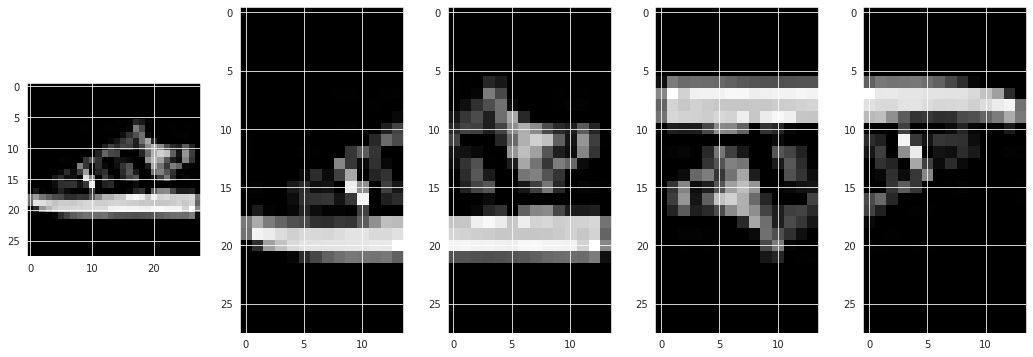

In [16]:
# Here is an image of a fashion item. Firstly the original (left), then patch (middle), then augmented patch (right)
fig, axes = plt.subplots(1, 5, figsize = (18, 6))

g2 = axes[0].imshow(np.squeeze(images[0]), cmap='gray')

g3 = axes[1].imshow(np.squeeze(patch_aug[0]), cmap='gray')
g4 = axes[2].imshow(np.squeeze(patch_aug[1]), cmap='gray')

g4 = axes[3].imshow(np.squeeze(patch_aug[120001]), cmap='gray')
g4 = axes[4].imshow(np.squeeze(patch_aug[120000]), cmap='gray')

plt.show()



---



---



# Transformed Input Data

The data is first vectorized, then split into training and validation sets. A dataloader is then used to allow its passage through the network.

In [17]:
# Vectorize features
patch_aug = torch.flatten(patch_aug, start_dim=2)
print(patch_aug.size())

torch.Size([240000, 1, 392])


In [18]:
# Split dataset into training and validation sets
split = int(len(label_aug)*0.9)

train_patch = patch_aug[:split]
train_labels = label_aug[:split]

test_patch = patch_aug[split:]
test_labels = label_aug[split:]

print(test_patch.size())

torch.Size([24000, 1, 392])


In [19]:
# Create new tensor dataset
train_dataset = TensorDataset(train_patch, train_labels)
test_dataset = TensorDataset(test_patch, test_labels)

# Iterate through new dataset
train_dataloader = DataLoader(train_dataset, batch_size=2048)
test_dataloader = DataLoader(test_dataset, batch_size=2048, shuffle=True)



---



---



# **Section 2: Model**

# Layers

In [20]:
# NNDL
class Net(torch.nn.Module):
    def __init__(self, num_inputs, num_hidden1, num_hidden2, num_hidden3, num_hidden4, num_outputs):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.num_hidden1 = num_hidden1
        self.num_hidden2 = num_hidden2
        self.num_hidden3 = num_hidden3
        self.num_hidden4 = num_hidden4

        self.num_outputs = num_outputs
        
        self.Linear1 = nn.Linear(num_inputs, num_hidden1)
        self.Linear2 = nn.Linear(num_hidden1, num_hidden2)
        self.Linear3 = nn.Linear(num_hidden2, num_hidden3)
        self.Linear4 = nn.Linear(num_hidden3, num_hidden4)

        self.Linear5 = nn.Linear(num_hidden4, num_outputs)

        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = x.view(-1, self.num_inputs)
        x = self.Linear1(x)
        x = self.relu(x)
        x = self.Linear2(x)
        x = self.relu(x)
        x = self.Linear3(x)
        x = self.relu(x)
        x = self.Linear4(x)
        x = self.relu(x)
        x = self.Linear5(x)

        out = self.softmax(x)
        return out



---



---



# Hyperparameters

In [21]:
num_inputs, num_hidden1, num_hidden2, num_hidden3, num_hidden4, num_outputs = 28*14, 512, 392, 256, 100, 10    # Neurons

net = Net(num_inputs, num_hidden1, num_hidden2, num_hidden3, num_hidden4, num_outputs)    # Form network
network = net

loss_f = nn.CrossEntropyLoss()    # Loss function
lr, wd = 35e-4, 35e-7     # learning rate and weight decay (regularisation)

optimizer = Adam(net.parameters(), lr=lr, weight_decay=wd)     # Optimiser

In [22]:
# Get the true loss and accuracies
def lost(y_true, y_pred):
    y_true = y_true.long().squeeze()
    return loss_f(y_pred, y_true)

def acc(y_true, y_pred):
    y_true = y_true.long().squeeze()
    y_pred = torch.argmax(y_pred, axis=1)
    eq = (y_true == y_pred).float()
    size = len(y_true)
    return eq.sum()/size



---



---



# **Section 3: Training Pipleine**

# Model Training

In [23]:
print("Initializing Training \n")

# Initialise epochs
n_epochs = 30

# Create result storage
t_loss_store, v_loss_store = [], []
t_acc_store, v_acc_store = [], []

# Repeat for each epoch
for epoch in range(n_epochs):

    # Train Network
    net = net.train()

    # Batch storage
    batch_t_loss_store, batch_t_acc_store = [], []
    batch = 0

    tot_t_loss = 0
    tot_t_points = 0
    tot_t_acc = 0

    # For each batch in iteration loader
    for t_batch in train_dataloader:
        t_X, t_y = t_batch

        # Get training resultant values
        t_pred = net.forward(t_X)
        t_loss = lost(t_y, t_pred)
        t_acc = acc(t_y, t_pred)
        
        # Apply optimizer and loss functions
        optimizer.zero_grad()     # Do not calculate gradient
        t_loss.backward()         # Compute gradient backward
        
        # Update parameters
        optimizer.step()

        # Set increments
        tot_t_points += 1
        tot_t_loss += t_loss.item()
        tot_t_acc += t_acc.item()

        # Get Training resultant values
        t_loss = np.round(t_loss.item(), 3)
        t_acc = np.round(t_acc.item(), 3)

        batch = batch + 1
        
        # Update batch storage
        batch_t_loss_store.append(t_loss)
        batch_t_acc_store.append(t_acc)
        
    # Update result storage
    t_loss_store.append(np.mean(batch_t_loss_store))
    t_acc_store.append(np.mean(batch_t_acc_store))

    
    # Begin tests
    for v_batch in test_dataloader:
        v_X, v_y = v_batch

        tot_v_loss = 0
        tot_v_points = 0
        tot_v_acc = 0

        # Get Validation resultant values
        v_pred = net.forward(v_X)
        v_loss = lost(v_y, v_pred)
        v_acc = acc(v_y, v_pred)
            
        # Increments
        tot_v_points += 1
        tot_v_loss += v_loss.item()
        tot_v_acc += v_acc.item()

    # Test trained model on validation dataset
    with torch.no_grad():
        for v_batch in test_dataloader:
            v_X, v_y = v_batch

            # Get validation resultant values
            v_pred = net.forward(v_X)
            v_loss = lost(v_y, v_pred)
            v_accuracy = acc(v_y, v_pred)
            
            # Set increments
            tot_v_points += 1
            tot_v_loss += v_loss.item()
            tot_v_acc += v_acc.item()
    
    # Calculate final results
    v_loss = np.round(tot_v_loss/tot_v_points, 3)
    v_acc = np.round(tot_v_acc/tot_v_points, 3)
    
    # Append to storage
    v_loss_store.append(v_loss)
    v_acc_store.append(v_acc)
    
    # Print final results
    results = "Epoch: {} || Train Loss: {} || Train Acc: {} || Valid Loss: {} || Valid Acc: {}"
    print("\n" + results.format(epoch + 1, t_loss, t_acc, v_loss, v_acc) + "\n")
    
print("Training Complete")

Initializing Training 


Epoch: 1 || Train Loss: 0.721 || Train Acc: 0.74 || Valid Loss: 0.653 || Valid Acc: 0.762


Epoch: 2 || Train Loss: 0.628 || Train Acc: 0.768 || Valid Loss: 0.545 || Valid Acc: 0.811


Epoch: 3 || Train Loss: 0.546 || Train Acc: 0.794 || Valid Loss: 0.497 || Valid Acc: 0.826


Epoch: 4 || Train Loss: 0.492 || Train Acc: 0.81 || Valid Loss: 0.465 || Valid Acc: 0.82


Epoch: 5 || Train Loss: 0.462 || Train Acc: 0.826 || Valid Loss: 0.434 || Valid Acc: 0.843


Epoch: 6 || Train Loss: 0.445 || Train Acc: 0.836 || Valid Loss: 0.423 || Valid Acc: 0.836


Epoch: 7 || Train Loss: 0.424 || Train Acc: 0.849 || Valid Loss: 0.414 || Valid Acc: 0.857


Epoch: 8 || Train Loss: 0.41 || Train Acc: 0.854 || Valid Loss: 0.411 || Valid Acc: 0.847


Epoch: 9 || Train Loss: 0.397 || Train Acc: 0.86 || Valid Loss: 0.405 || Valid Acc: 0.856


Epoch: 10 || Train Loss: 0.378 || Train Acc: 0.857 || Valid Loss: 0.396 || Valid Acc: 0.854


Epoch: 11 || Train Loss: 0.368 || Train Acc: 0.86



---



---



# **Section 4: Results**

# Model Performance

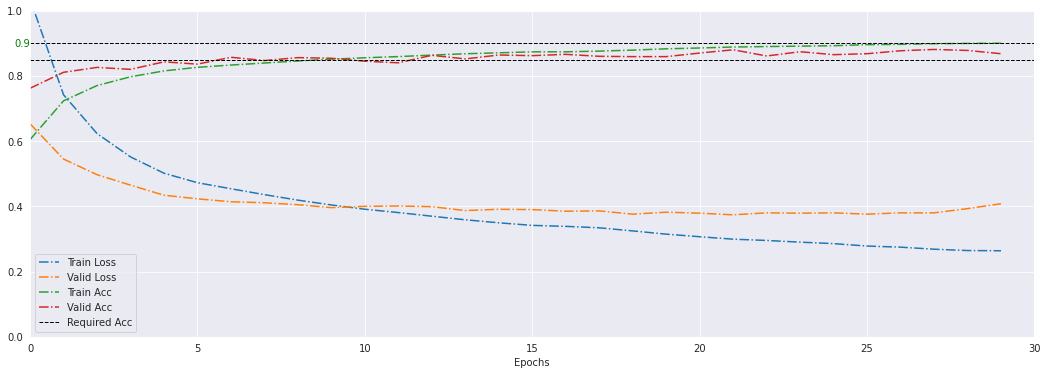

In [24]:
# Visualise model performance
fig,ax = plt.subplots(1,1, figsize=(18,6))

plt.plot(t_loss_store, linestyle='-.', label='Train Loss')
plt.plot(v_loss_store, linestyle='-.', label='Valid Loss')
plt.plot(t_acc_store, linestyle='-.', label='Train Acc')
plt.plot(v_acc_store, linestyle='-.', label='Valid Acc')

plt.ylim(0, 1)
plt.xlim(0, n_epochs)

# Add in dotted line for desired accuracies
ax.axhline(0.9, linewidth=1, color='k', linestyle='--', label='Required Acc')
ax.axhline(0.85, linewidth=1, color='k', linestyle='--')
ax.text(0, 0.9, 0.9,color="green", ha="right", va="center")

ax.set_xlabel('Epochs')

plt.legend()
plt.show()



---



---



# Classification Results

The model has the most difficulty classifying shirts, t-shirts and pullovers. This is understandable as they are visually similar.

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

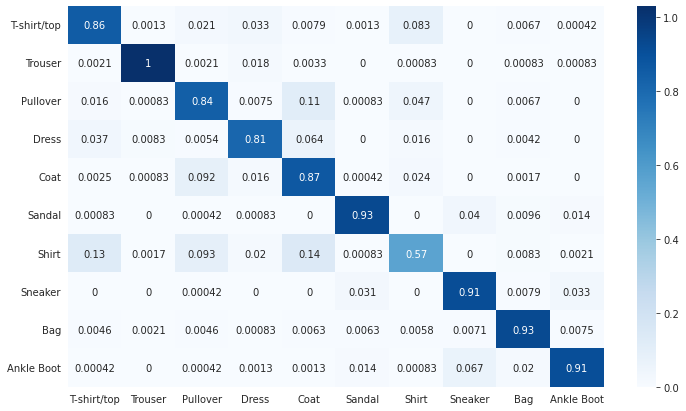

In [25]:
# Link 2
# Confusion matrix

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dataloader:
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True, cmap='Blues')
plt.savefig('output.png')